In [24]:
# Integración numérica de sistemas de ecuaciones diferenciales ordinarias
from scipy.integrate import solve_ivp

# Minimización de funciones objetivos para ajuste de parámetros
from scipy.optimize import least_squares

# Ecuaciones no lineales
from scipy.optimize import fsolve

import numpy as np
import matplotlib.pyplot as plt
import copy

#### Definición sistema de ecuaciones diferenciales

In [25]:
# Función que es entregada a solve_ivp para resolver el modelo, se le entregara un BOOLEANO
# Para determinar si es carga o descarga

# Ec. no lineal para encontrar el valor de la presión para un valor
# de masa total conocida

def p_eqn(p, n_0, R, T, alpha, beta, b, p_0, M_H2, m_s, volumen, epsilon, m_t):
    # Calcular varias veces las variables
    # Calcular moles de hidrógeno adsorbido f(T,p)
    n_a = n_0 * np.exp(-((R*T)/(alpha+beta*T))**b * np.log(p_0/p)**b)
    # Actualizar masa adsorbida
    m_a = n_a*M_H2*m_s
    # Actualizar masa gas
    # Moles gas
    n_g = p*(volumen*epsilon)/(R*T)
    # Masa gas
    m_g = n_g * M_H2
    return m_t - (m_a + m_g)


def adsorcion_hidrogeno(t, y, c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon, volumen, area, p_0, n_0, b, m_dot, h, h_f, T_f, charge, DEBUG=False):
    
    # Desempacar variables:
    m_t = y[0]
    T = y[1]
    
    # Calcular Variables dependientes de las variables independientes
    p_old = 0.033*1e6 # Presión inicial (Pa) para test No. 13

    # Nueva presión 
    p = fsolve(p_eqn, p_old, args = (n_0, R, T, alpha, beta, b, p_0, M_H2, m_s, volumen, epsilon, m_t))

    # Calcular masa adsorbida
    # Moles adsorbidos
    n_a = n_0 * np.exp(-((R*T)/(alpha+beta*T))**b * np.log(p_0/p)**b)
    # Masa adsorbida
    m_a = n_a*M_H2*m_s

    # Actualizar la masa en la fase gas
    m_g = m_t - m_a

    # Calor esostérico
    dH = alpha * (np.log(p_0/p))**(1/b)
    
    # ECUACIONES DIFERENCIALES
    # Ecuación diferencial de masa total
    if charge:
        dm_dt = m_dot
    elif not charge:
        dm_dt = -m_dot
    else:
        dm_dt = 0
        
    # Ecuación diferencial de temperatura
    if charge:
        dT_dt = (m_dot*h + dm_dt*(dH/M_H2) - h_f*area*(T-T_f))/(m_s*c_s + m_a*c_p + m_g*c_p + m_w*c_w)
    elif not charge:
        dT_dt = (-m_dot*h + dm_dt*(dH/M_H2) - h_f*area*(T-T_f))/(m_s*c_s + m_a*c_p + m_g*c_p + m_w*c_w)
    
    # DEBUG prints
    if DEBUG is True:
        print("\ndT_dt debugging \n")
        print("dT_dt = %.3e K/s" % dT_dt)
        print("m_dot = %.3e kg/s" % m_dot)
        print("h = %.3e Jm^2-" % h)
        print("dH = %.3e J/kg " % dH)
        print("M_H2 = %.3e kg/mol" % h)
        print("h_f = %.3e Wm^-2K^-1" % h_f)
        print("area = %.3e m^2" % area)
        print("T = %.3e K" % T)
        print("T_f = %.3e K" % T_f)        
        print("dm_dt = %.3e kg/s" % dm_dt)
        # Calor isoestérico
        print("\nIsosteric heat debugging\n")
        print("alpha = %.3e" % alpha)
        print("b= %.3e" % b)
        print("p_0 = %.3e Pa" % p_0)
        print("p = %.3e Pa" % p)

    # Empacar el vector del lado derecho en un vector 2x1
    dy = np.array([dm_dt, dT_dt])
    
    return dy

#### Parametros, condiciones y solve_ivp

In [26]:
# PARAMETROS
# Calores especificos
c_s = 825 # Calor especifico del carbón activado (J kg-1 K-1)
c_p = 10167 # Calor especifico del hidrogeno (J kg-1 K-1)
c_w = 468 # Calor especifico paredes de acero (J kg-1 K-1)


# Masas
m_s = 0.671 # masa carbón activado (kg)
m_w = 3.714 # Masa paredes de acero (kg)
M_H2 = 2.0159E-3 # Masa molar del hidregeno (kg mol-1)

# Constantes 
R = 8.314 # J mol-1 K-1
alpha = 3080 # Factor entalpico (J mol-1)
beta = 18.9 # Factor entropico (J mol-1 K-1)
epsilon_b = 0.49 
b = 2

# Dimensiones estanque
V = 2.4946*1e-3 # Volumen de estanque (m^3)
A_e = 0.1277 # Área superficial estanque m^2

# Otros
p_0 = 1470 * 1e6 # Presion de saturacion (Pa)
n_0 = 71.6 # Cantidad limite de adsorcion (mol kg-1)


# CONDICIONES INICIALES
p_ci = np.array([0.033, 0.033, 0.033, 0.032, 0.049, 0.032])*1e6 # Presión inicial (Pa)
T_ci = np.array([281, 282, 280.2, 301.5, 302, 302.4]) # Temperatura inicial (K) 
T_cf = np.array([282.5, 284.5, 282.2, 301.7, 302.5, 302.5]) # Temperatura refrigerante (K)
h_cf = np.array([36, 36, 36, 36, 36, 36]) # Coeficiente de transferencia de calor (W m^-2 K^-1)

# Seleccionar los valores del test deseado
p_i = p_ci[0]
T_i = T_ci[0]
T_f = T_cf[0]
h_f = h_cf[0]

# Número de moles adsorbidos en t = 0
n_a0 = n_0 * np.exp(- (R*T_i/(alpha + beta*T_i))**b * np.log(p_0/p_i)**b )

# Numero inicial de moles en la fase gas a partir de las condiciones iniciales
n_gi = p_i*(V*epsilon_b)/(R*T_i)
m_gi = n_gi * M_H2
print("n_g = %.3e moles" % n_gi)
# Masa inicial de hidrógeno en la fase gas
print("m_g = %.3e kg" % m_gi)
# Masa inicial de hidrógeno adsorbido
print("m_a = %.3e kg" % (n_a0*M_H2))
# Masa inicial total
m_ti = (n_a0+n_gi)*M_H2
# m_ti = 0
print("m_ti = %.3e kg" % m_ti)

print("---Condiciones iniciales---")
print("n_a0 = %.3f" % n_a0)
print(f'La presión incial es: {p_i} Pa \nLa temperatura inicial es: {T_i} K \nLa temperatura final es: {T_f}\n K h_f es: {h_f}')
print("---Fin CI---\n")

# PARAMETROS EN CARGA/DESCARGA
# Carga o descarga?
charge = True

# Por ahora solo se usara test No. 13
t_0 =  0            # s
t_f = 1042          # s
t_range = np.linspace(t_0, t_f, 100000) # Intervalo de tiempo para el proceso de carga en test No. 13

m_dot = 2.023e-5    # Caudal másico (kg s-1)

# Entalpía?
h = 3986.8          # J/kg 

# Tupla de parametros que se deben pasar a solve_ivp
DEBUG = False
args = (c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon_b, V, A_e, p_0, n_0, b, m_dot, h, h_f, T_f, charge, DEBUG)

# En ingeniería química, sobre todo cuando hay reacciones o cambio de fases, se generan sistemas ultraestables
# (ultrastiff) no conviene utilizar métodos explícitos. 
print('---Test case 13---')
sol = solve_ivp(adsorcion_hidrogeno, (t_0, t_f), [m_ti, T_i], args=args, t_eval= t_range, method = 'BDF')

n_g = 1.727e-02 moles
m_g = 3.481e-05 kg
m_a = 2.004e-05 kg
m_ti = 5.484e-05 kg
---Condiciones iniciales---
n_a0 = 0.010
La presión incial es: 33000.0 Pa 
La temperatura inicial es: 281.0 K 
La temperatura final es: 282.5
 K h_f es: 36
---Fin CI---

---Test case 13---


C:\Users\kiera\AppData\Local\Temp\ipykernel_10300\242315847.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dy = np.array([dm_dt, dT_dt])


In [27]:
# Desempacar la sol.clear
m_t = sol.y[0]
T = sol.y[1]

# Conseguir la cantidad de soluciones
num = len(T)

### Graficar la solución

#### Temperatura

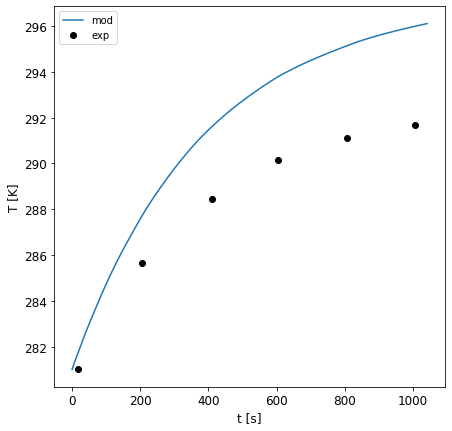

In [36]:
plt.figure(figsize = [7,7])

# Temperatura
plt.plot(sol.t, T, label='mod')
plt.xlabel('t [s]', size = 12)
plt.ylabel('T [K]', size = 12)

# Se extrajeron los datos usando WebPlotDigitizer
t_exp = [18.633540372670836, 204.96894409937886, 409.9378881987577, 605.5900621118014, 805.9006211180124, 1006.2111801242236]
T_exp = [281.0010449320794, 285.6530825496343, 288.43260188087777, 290.15882967607104, 291.1243469174504, 291.6802507836991]

# Graficamos los experimentos
plt.plot(t_exp, T_exp, label='exp', marker ='o', ls='', color='k')

# Estética
plt.xlabel('t [s]', size = 12)
plt.ylabel('T [K]', size = 12)

# Visualización
# Agrandar el tamaño de los números en el gráfico
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

#### Presión 

In [19]:
# Como calculamos P, m_a y m_g?
p = []

for i in range(len(T)):
    # Se encuentra el valor de la presión mediante la función fsolve
    p_inst = fsolve(p_eqn, p_i, args = (n_0, R, T[i], alpha, beta, b, p_0, M_H2, m_s, V, epsilon_b, m_t[i]))
    # Se extrae el valor en el indice 0 porque p_inst es de la forma [float]
    # Se divide en 1e6 para pasar de Pa a MPa
    p_inst = p_inst[0]
    
    if i % 100000 == 0:
        print(f'En el indice [{i}] la presión es: {p_inst} Pa')

    p.append(p_inst)

p = np.array(p)
print(p[-1])

En el indice [0] la presión es: 36762.24207051624 Pa
9073251.672918614


Gráfico

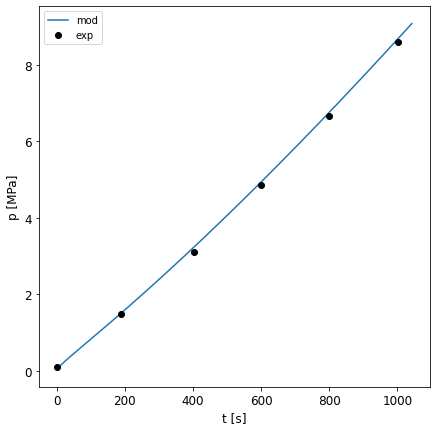

In [35]:
plt.figure(figsize = [7,7])
plt.plot(sol.t, p/1e6, label='mod')


### Validación experimental:

# Se extrajeron los datos usando WebPlotDigitizer
t_exp = np.array([0, 189.8370086, 402.6845638, 598.274209, 799.6164909, 1000.958773])
p_exp = np.array([0.102564103, 1.487179487, 3.115384615, 4.858974359, 6.666666667, 8.58974359])

# Graficamos los experimentos
plt.plot(t_exp, p_exp, label='exp', marker ='o', ls='', color='k')

# Estética
plt.xlabel('t [s]', size = 12)
plt.ylabel('p [MPa]', size = 12)

# Visualización
# Agrandar el tamaño de los números en el gráfico
plt.tick_params(labelsize=12)
plt.legend()
plt.show()


#### Masa fase adsorbida y fase gaseosa

<function matplotlib.pyplot.show(close=None, block=None)>

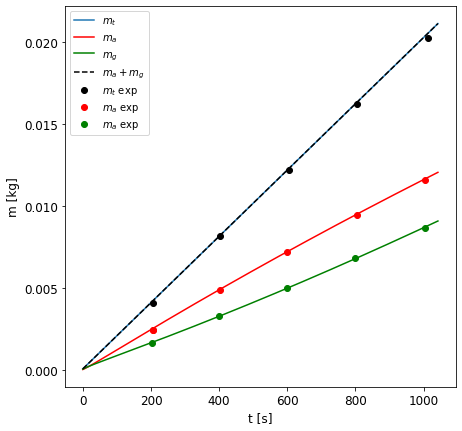

In [47]:
# Masa
n_a = n_0*np.exp(-((R*T)/(alpha+beta*T))**b * np.log(p_0/p)**b)
m_a = n_a*M_H2*m_s
m_a = np.array(m_a)
m_g = M_H2*p*(V*epsilon_b)/(R*T) 

plt.figure(figsize = [7,7])

plt.plot(sol.t, m_t, label='$m_t$')
plt.plot(sol.t, m_a, color='r', label='$m_a$')
plt.plot(sol.t, m_g, color='g', label='$m_g$')
plt.plot(sol.t, m_g + m_a, ls="--", color='k', label='$m_a + m_g$')
plt.xlabel('t [s]', size = 12)
plt.ylabel('m [kg]', size = 12)

# Se extrajeron los datos usando WebPlotDigitizer
t_expmt = [206.77811171280962, 402.42787695802133, 603.6383529770229, 804.8349791559907, 1011.6061659487831]
mt_exp = [0.004083135973112845, 0.008138823871584282, 0.012194537161429117, 0.016195455867484727, 0.020251194548702958]
t_expma = [206.3591540517706, 206.3591540517706, 401.6003490159691, 599.590737226985, 803.1245239117487, 1003.8571804495658]
ma_exp = [0.0024255998134888185, 0.0024255998134888185, 0.00486484749017815, 0.007180820049028432, 0.009428324769515576, 0.011593624918632186]
t_expmg = [203.38490090439484, 398.4183482680777, 599.0402060856201, 799.6828386632134, 1003.1196764677369]
mg_exp = [0.001658462944752987, 0.0032757918646039615, 0.005002735343406783, 0.006811870697893439, 0.008675813331856016]

# Graficamos los experimentos
plt.plot(t_expmt, mt_exp, label='$m_t$ exp', marker ='o', ls='', color='k')
plt.plot(t_expma, ma_exp, label='$m_a$ exp', marker ='o', ls='', color='r')
plt.plot(t_expmg, mg_exp, label='$m_a$ exp', marker ='o', ls='', color='g')

# Agrandar el tamaño de los números en el gráfico
plt.tick_params(labelsize=12)

plt.legend()
plt.show

### Reposo

No completado

### Test No. 15

In [9]:
# Seleccionar los valores del test deseado
p_i = p_ci[1]
T_i = T_ci[1]
T_f = T_cf[1]
h_f = h_cf[1]

n_a0 = n_0 * np.exp(- (R*T_i/(alpha + beta*T_i))**b * np.log(p_0/p_i)**b )

n_gi = p_i*(V*epsilon_b)/(R*T_i)
m_gi = n_gi * M_H2

# PARAMETROS EN CARGA/DESCARGA
# Carga o descarga?
charge = True

# Por ahora solo se usara test No. 13
t_0 =  0            # s
t_f = 422           # s
t_range = np.linspace(t_0, t_f, 100000)

m_dot = 4.362e-5        # kg s-1

# Aparentemente calor de 
h = 4001.1          # J/kg aparentemente mal en el paper

# Tupla de parametros que se deben pasar a solve_ivp
DEBUG = False
args = (c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon_b, V, A_e, p_0, n_0, b, m_dot, h, h_f, T_f, charge, DEBUG)

# En ingeniería química, sobre todo cuando hay reacciones o cambio de fases, se generan sistemas ultraestables
# (ultrastiff) no conviene utilizar métodos explícitos. 
sol = solve_ivp(adsorcion_hidrogeno, (t_0, t_f), [m_ti, T_i], args=args, t_eval= t_range, method = 'BDF')

C:\Users\kiera\AppData\Local\Temp\ipykernel_10300\2791749424.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dy = np.array([dm_dt, dT_dt])


In [10]:
# Desempacar la sol.clear
m_t = sol.y[0]
T = sol.y[1]

# Conseguir la cantidad de soluciones
num = len(T)

Text(0, 0.5, 'T [K]')

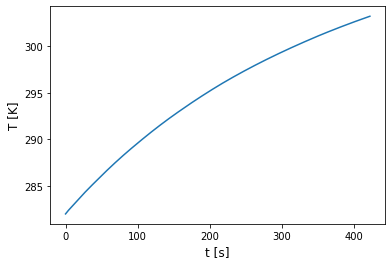

In [11]:
# Temperatura
plt.plot(sol.t, T)
plt.xlabel('t [s]', size = 12)
plt.ylabel('T [K]', size = 12)

En el indice [0] la presión es: 37045.90510331308 Pa


Text(0, 0.5, 'presión [MPa]')

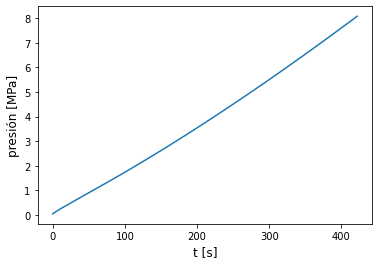

In [12]:
# Como calculamos P, m_a y m_g?
p = []

for i in range(len(T)):
    # Se encuentra el valor de la presión mediante la función fsolve
    p_inst = fsolve(p_eqn, p_i, args = (n_0, R, T[i], alpha, beta, b, p_0, M_H2, m_s, V, epsilon_b, m_t[i]))
    # Se extrae el valor en el indice 0 porque p_inst es de la forma [float]
    # Se divide en 1e6 para pasar de Pa a MPa
    p_inst = p_inst[0]
    
    if i % 100000 == 0:
        print(f'En el indice [{i}] la presión es: {p_inst} Pa')

    p.append(p_inst)

p = np.array(p)


plt.plot(sol.t, p/1e6)
plt.xlabel('t [s]', size = 12)
plt.ylabel('presión [MPa]', size = 12)

Text(0, 0.5, 'm [kg]')

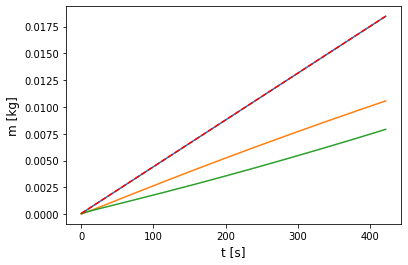

In [13]:
# Masa
n_a = n_0*np.exp(-((R*T)/(alpha+beta*T))**b * np.log(p_0/p)**b)
m_a = n_a*M_H2*m_s
m_a = np.array(m_a)
m_g = M_H2*p*(V*epsilon_b)/(R*T) 

plt.plot(sol.t, m_t)
plt.plot(sol.t, m_a)
plt.plot(sol.t, m_g)
plt.plot(sol.t, m_g + m_a, "r--")
plt.xlabel('t [s]', size = 12)
plt.ylabel('m [kg]', size = 12)